## Boruta SHAP Feature Selection

In this notebook I will explore the use of the Boruta-SHAP Feature Selection Method

### Imports

In [4]:
import pandas as pd
import numpy as np

In [5]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from scipy.special import softmax

In [6]:
from BorutaShap import BorutaShap
import shap

### Functions

In [7]:
def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = random_forest_model.feature_importances_
    features = random_forest_model.feature_names_in_
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

In [8]:
def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [9]:
def evaluate_regression(y, y_pred):
    
    '''
    Prints the most common evaluation metrics for regression
    '''
    
    mae = MAE(y, y_pred)
    mse = MSE(y, y_pred)
    rmse = mse ** (1/2)
    r2 = R2(y, y_pred)
    
    print('Regression result')
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2: {r2:.2f}")

### Loading the Dataset
California Housing dataset

In [10]:
# Fetches the data
# dataset = fetch_california_housing(as_frame = True)
dataset = load_diabetes(as_frame = True)

In [11]:
# Gets the independent variables
X = dataset['data']
X.head(5)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


In [12]:
# Checks the shape of the data
X.shape

(442, 10)

In [13]:
# Gets the dependent variable (the target)
y = dataset['target']
y.head(5)

0    151.0
1     75.0
2    141.0
3    206.0
4    135.0
Name: target, dtype: float64

### Create a simple regression

In order to compare results before and after applying Boruta Shap feature selection, we will fisrt run a simple regression

In [14]:
# Prepares a default instance of the random forest regressor
model = RandomForestRegressor()

In [15]:
# Fits the model on the data
model.fit(X, y)

RandomForestRegressor()

In [16]:
# Evaluates the model
y_pred = model.predict(X)
evaluate_regression(y, y_pred)

Regression result
MAE: 17.44
MSE: 468.30
RMSE: 21.64
R2: 0.92


In [17]:
# Prints the feature importances
print_feature_importances_random_forest(model)

s5 -> 0.3101
bmi -> 0.2711
bp -> 0.0985
s6 -> 0.0680
age -> 0.0596
s2 -> 0.0580
s3 -> 0.0516
s1 -> 0.0453
s4 -> 0.0256
sex -> 0.0121


### SHAP evaluation

In [18]:
# Fits the explainer
explainer = shap.Explainer(model.predict, X)

In [19]:
# Calculates the SHAP values - It takes some time
shap_values = explainer(X)

Exact explainer: 443it [03:34,  1.98it/s]                         


In [20]:
# Prints the SHAP feature importances
print_feature_importances_shap_values(shap_values, X.columns)

s5 -> 23.9909 (softmax = 0.8415)
bmi -> 22.3215 (softmax = 0.1585)
bp -> 8.1369 (softmax = 0.0000)
s3 -> 5.2180 (softmax = 0.0000)
s6 -> 4.4359 (softmax = 0.0000)
age -> 3.9110 (softmax = 0.0000)
sex -> 3.3272 (softmax = 0.0000)
s2 -> 2.9382 (softmax = 0.0000)
s4 -> 2.4428 (softmax = 0.0000)
s1 -> 2.1223 (softmax = 0.0000)


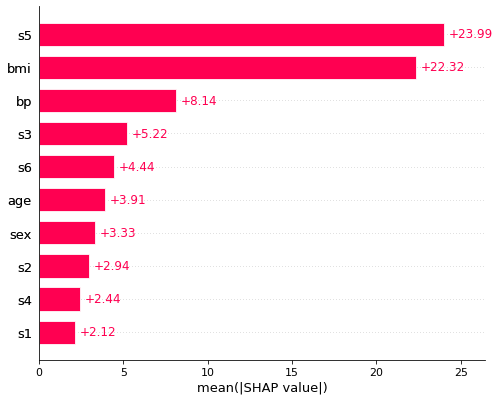

In [21]:
# Plots this view
shap.plots.bar(shap_values)

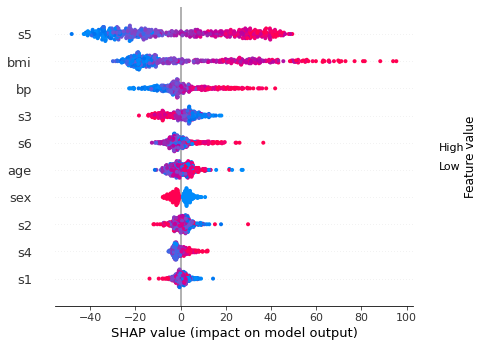

In [22]:
# Plots the beeswarm
shap.plots.beeswarm(shap_values)

### Select features using Boruta-SHAP

In [23]:
# Creates a BorutaShap selector for regression
selector = BorutaShap(importance_measure = 'shap', classification = False)

In [24]:
# Fits the selector
selector.fit(X = X, y = y, n_trials = 20, sample = False, verbose = True)
# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

  0%|          | 0/20 [00:00<?, ?it/s]

4 attributes confirmed important: ['bmi', 's5', 's3', 'bp']
5 attributes confirmed unimportant: ['s2', 's1', 'age', 's4', 'sex']
1 tentative attributes remains: ['s6']


In [25]:
# Display features to be removed
features_to_remove = selector.features_to_remove
features_to_remove

array(['age', 'sex', 's1', 's2', 's4'], dtype=object)

In [26]:
# Removes them
X_new = X.drop(columns = features_to_remove)

### Fits a new regression model to the new data

In [27]:
# Prepares a default instance of the random forest regressor
model_new = RandomForestRegressor()

In [28]:
# Fits the model on the data
model_new.fit(X_new, y)

RandomForestRegressor()

In [29]:
# Evaluates the model
y_pred_new = model_new.predict(X_new)
evaluate_regression(y, y_pred_new)

Regression result
MAE: 17.77
MSE: 489.96
RMSE: 22.14
R2: 0.92


In [30]:
# Prints the feature importances
print_feature_importances_random_forest(model_new)

s5 -> 0.3365
bmi -> 0.3268
bp -> 0.1359
s6 -> 0.1067
s3 -> 0.0940


In [31]:
# Fits the explainer
explainer_new = shap.Explainer(model_new.predict, X_new)

In [32]:
# Calculates the SHAP values - It takes some time
shap_values = explainer_new(X_new)

Exact explainer: 443it [00:16, 11.12it/s]                         


In [33]:
# Prints the SHAP feature importances
print_feature_importances_shap_values(shap_values, X.columns)

bp -> 23.5722 (softmax = 0.7566)
age -> 22.4380 (softmax = 0.2434)
sex -> 9.6980 (softmax = 0.0000)
s1 -> 6.6932 (softmax = 0.0000)
bmi -> 6.5323 (softmax = 0.0000)


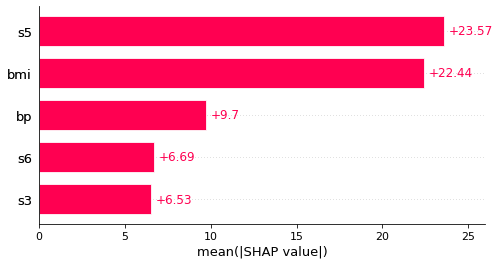

In [34]:
# Plots this view
shap.plots.bar(shap_values)

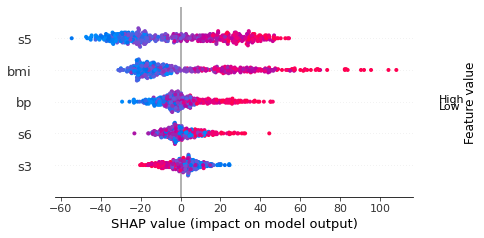

In [35]:
# Plots the beeswarm
shap.plots.beeswarm(shap_values, max_display=14)